# Quickstart Example

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

# plotting config

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 15
colors = ["#807fff", "#fd7f82", "#84a97e"]
sns.set_palette(sns.color_palette(colors))

In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

random_seed = 42

import numpy as np
np.random.seed(random_seed)

## Data Loading and Processing

In [3]:
import numpy as np
from sklearn import datasets

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only one feature
diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
X_train = diabetes_X[:-100]
X_test = diabetes_X[-100:]

# Split the targets into training/testing sets
y_train = diabetes_y[:-100]
y_test = diabetes_y[-100:]

# Split fit and calibration data
X_fit, X_calib = X_train[:-100], X_train[-100:]
y_fit, y_calib = y_train[:-100], y_train[-100:]

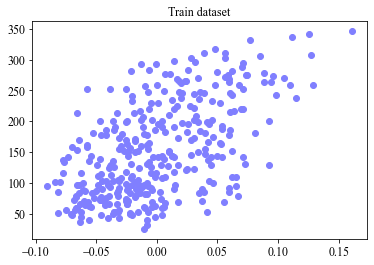

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.scatter(X_train, y_train)
plt.title("Train dataset")
plt.show()

## Model Definition

In [5]:
from sklearn import linear_model

# Create linear regression object
regr = linear_model.LinearRegression()

## Quantification of uncertainty using conformal prediction

In the following, we show two ways of defining and using conformal prediction wrappers:
- A fast way based on the high-level API 
- A flexible way based of full customization of the prediction model, the residual computation and the fitting/calibration split plan   

For all the following experiments, the miscoverage level is set to 10%.

In [6]:
# Miscoverage target
alpha=.1

### High-level conformal prediction

Here is an example of using Split CP from the high-level API.

In [7]:
from deel.puncc.regression import SplitCP

# The regression model is provided during split cp object instantiation
split_cp = SplitCP(regr) 
# The fit method trains the model and computes the residuals on the calibration set
split_cp.fit(X_fit, y_fit, X_calib, y_calib)
# The predict method infers prediction intervals with respect to the risk alpha
y_pred, y_pred_lower, y_pred_upper = split_cp.predict(X_test, alpha=alpha)

#### Results

Empirical coverage : 95.0%
Sharpness (PI average width) : 211.4


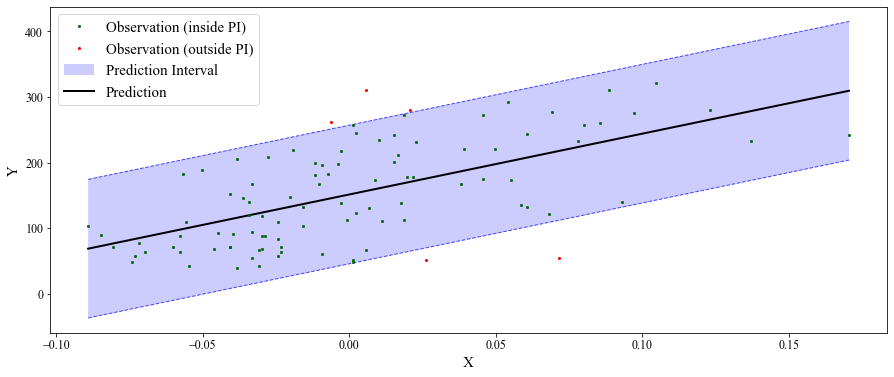

In [8]:
import numpy as np
from deel.puncc.api.utils import plot_prediction_interval, average_coverage, sharpness

coverage = average_coverage(y_true=y_test, 
                            y_pred_lower=y_pred_lower, 
                            y_pred_upper=y_pred_upper)

pi_width = sharpness(y_pred_lower=y_pred_lower, 
                     y_pred_upper=y_pred_upper)

print(f"Empirical coverage : {np.round(coverage*100, 1)}%")
print(f"Sharpness (PI average width) : {np.round(pi_width, 1)}")

# Figure of the prediction bands

plot_prediction_interval(
    X = X_test[:,0],
    y_true=y_test,
    y_pred=y_pred,
    y_pred_lower=y_pred_lower,
    y_pred_upper=y_pred_upper,
    sort_X=True,
    size=(10, 6),
    loc="upper left")


### Fully customizable conformal prediction

We now define the same split conformal prediction wrapper as before using the fully customizable approach. Also, we showcase how flexible such approach is by tweaking some of its components.

#### Predictor

The linear model is wrapped by MeanPredictor object. For example, `MeanPredictor` can encapsulate any conditional mean estimator. 

In [9]:
from deel.puncc.api.prediction import MeanPredictor

# Mean-based predictor
mean_predictor = MeanPredictor(regr)

#### Calibrator

The calibrator instance provides a way of estimating the residual distribution on the calibration set. For example, `MeanCalibrator` computes the absolute deviation of the model from the conditional mean.

In [10]:
from deel.puncc.api.calibration import MeanCalibrator

# Mean-based calibrator
mean_calibrator = MeanCalibrator()

#### Conformalization

The `ConformalPredictor` assembles a `MeanPredictor`, a `MeanCalibrator` and a `IdSplitter` in a specific process to provide prediction intervals with a guaranteed coverage rate. 

In [11]:
from deel.puncc.api.conformalization import ConformalPredictor
from deel.puncc.api.splitting import IdSplitter

# Wrapper predetermined data schemes in the id splitter 
id_splitter = IdSplitter(X_fit, y_fit, X_calib, y_calib)
# Instanciate a conformal prediction object
split_conformal_predictor = ConformalPredictor(predictor=mean_predictor, 
                                               calibrator=mean_calibrator, 
                                               splitter=id_splitter,
                                               train=True)
# Fit model and compute nonconformity scores
split_conformal_predictor.fit(X_train, y_train)
# infer prediction interval w.r.t the level risk alpha
(y_pred, y_pred_lower, y_pred_upper, sigma_pred) = split_conformal_predictor.predict(
    X_test, alpha=alpha
)

Empirical coverage : 95.0%
Sharpness (PI average width) : 211.4


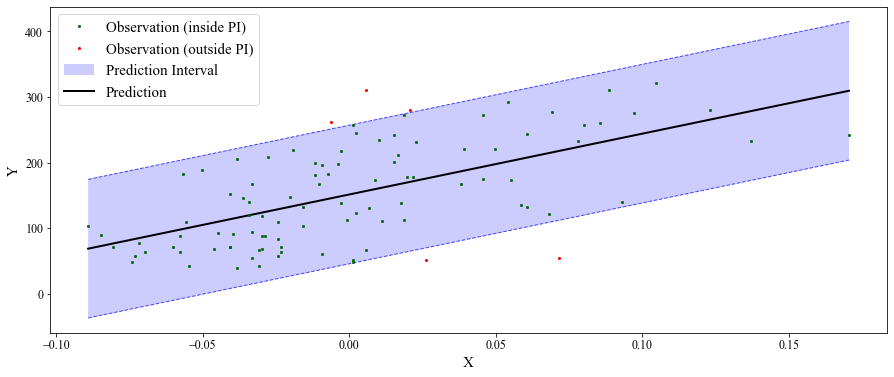

In [12]:
coverage = average_coverage(y_true=y_test, 
                            y_pred_lower=y_pred_lower, 
                            y_pred_upper=y_pred_upper)

pi_width = sharpness(y_pred_lower=y_pred_lower, 
                     y_pred_upper=y_pred_upper)

print(f"Empirical coverage : {np.round(coverage*100, 1)}%")
print(f"Sharpness (PI average width) : {np.round(pi_width, 1)}")

# Figure of the prediction bands

plot_prediction_interval(
    X = X_test[:,0],
    y_true=y_test,
    y_pred=y_pred,
    y_pred_lower=y_pred_lower,
    y_pred_upper=y_pred_upper,
    sort_X=True,
    size=(10, 6),
    loc="upper left")


As such, we obtain the same results as in the preconfigured wrapper. Notice that we have a conservative prediction interval, because the obtained empirical coverage is larger than the target.

Now let's try to have a tighter enveloppe by modifying the split plan into a K-fold. This is simply done by changing the generator argument in the `ConformalPredictor` constructor:

In [13]:
from deel.puncc.api.splitting import KFoldSplitter

# 20-fold data splitter
kfold_splitter = KFoldSplitter(K=20, random_state=random_seed)

# Only the splitter argument is changed from before
cv_conformal_predictor = ConformalPredictor(predictor=mean_predictor, 
                                            calibrator=mean_calibrator, 
                                            splitter=kfold_splitter,
                                            train=True)

cv_conformal_predictor.fit(X_train, y_train)

(y_pred, y_pred_lower, y_pred_upper, sigma_pred) = cv_conformal_predictor.predict(
    X_test, alpha=alpha
)

Empirical coverage : 95.0%
Sharpness (PI average width) : 209.0


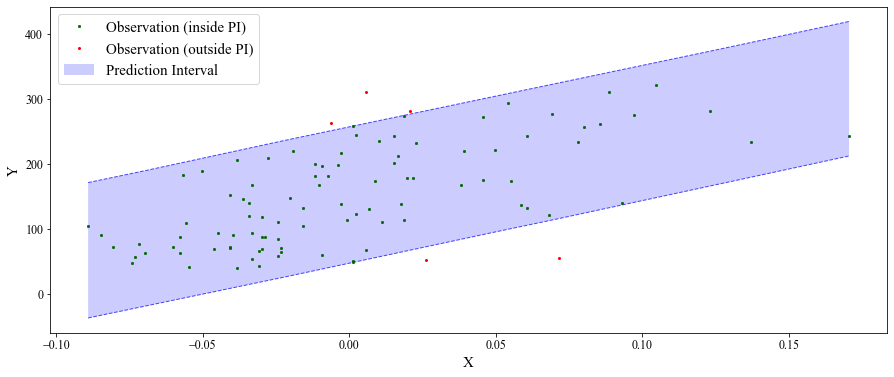

In [14]:
coverage = average_coverage(y_true=y_test, 
                            y_pred_lower=y_pred_lower, 
                            y_pred_upper=y_pred_upper)

pi_width = sharpness(y_pred_lower=y_pred_lower, 
                     y_pred_upper=y_pred_upper)

print(f"Empirical coverage : {np.round(coverage*100, 1)}%")
print(f"Sharpness (PI average width) : {np.round(pi_width, 1)}")

# Figure of the prediction bands

plot_prediction_interval(
    X = X_test[:,0],
    y_true=y_test,
    y_pred=y_pred,
    y_pred_lower=y_pred_lower,
    y_pred_upper=y_pred_upper,
    sort_X=True,
    size=(10, 6),
    loc="upper left")


Now, let's a state of the art method called EnbPI. This method is specifically tailored for case where data are not exchangeable.

In [ ]:
from deel.puncc.regression import EnbPI
from sklearn.ensemble import RandomForestRegressor

mu_rf = RandomForestRegressor(n_estimators=100, n_jobs=4, random_state=random_seed)

enbpi = EnbPI(mu_rf, B=30, agg_func_loo=np.mean)
enbpi.fit(X_train, y_train)
y_pred, y_pred_lower, y_pred_upper = enbpi.predict(X_test, alpha=alpha, y_true=y_test, s=None)

In [ ]:
coverage = average_coverage(y_true=y_test, 
                            y_pred_lower=y_pred_lower, 
                            y_pred_upper=y_pred_upper)

pi_width = sharpness(y_pred_lower=y_pred_lower, 
                     y_pred_upper=y_pred_upper)

print(f"Empirical coverage : {np.round(coverage*100, 1)}%")
print(f"Sharpness (PI average width) : {np.round(pi_width, 1)}")

# Figure of the prediction bands

plot_prediction_interval(
    X = X_test[:,0],
    y_true=y_test,
    y_pred=y_pred,
    y_pred_lower=y_pred_lower,
    y_pred_upper=y_pred_upper,
    sort_X=True,
    size=(10, 6),
    loc="upper left")